In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection_pre_now import Control_filter_selection_pre_now
from Fixed_filter_noise_cancellation_subfilters_initial import Fixed_filter_controller
from Disturbance_generation import Disturbance_generation_from_real_noise

print(torch.cuda.is_available())

True


In [3]:
# real noises
mdict = {}
fs = 16000
StepSize = 0.0001
sound_name = 'Mix_Aircraft_Traffic'
waveform, resample_rate = loading_real_wave_noise(folde_name='Noise Examples/', sound_name=sound_name+'.wav')

In [4]:
Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='Dongyuan', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1

In [5]:
print(waveform.shape)
print(Dis.shape)
print(Fx.shape)
print(Re.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160150])
torch.Size([160000])
torch.Size([160000])
torch.Size([160150])


The primary nosie has 10 seconds !!!
1 [0.98, 0.93, 0.64, 0.35, 0.23, 0.08, 0.1, 0.1, 0.03, 0.04, 0.03, 0.04, 0.03, 0.02, 0.03]
2 [1.0, 0.99, 0.74, 0.29, 0.13, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3 [1.0, 1.0, 0.74, 0.11, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4 [1.0, 1.0, 0.88, 0.1, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5 [1.0, 1.0, 0.94, 0.07, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6 [1.0, 1.0, 0.97, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
7 [1.0, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8 [1.0, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
9 [1.0, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 [1.0, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


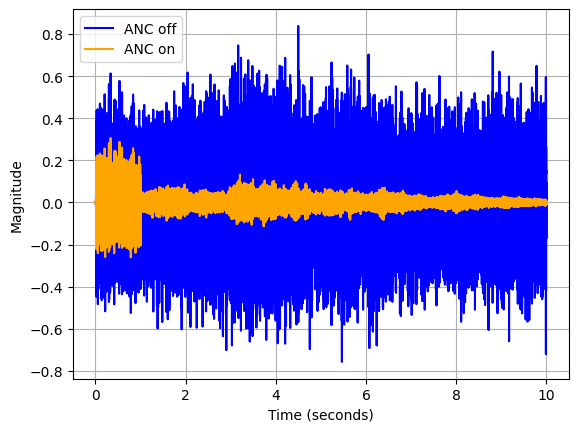

In [6]:
# GFANC based on Bayes filtering

MODEL_PTH = 'models/M6_res_Synthetic.pth'
path_mat = 'models/Pretrained_Sub_Control_filters.mat'

# prediction index
Filter_vector = Control_filter_selection_pre_now(fs=16000, MODEL_PTH=MODEL_PTH, path_mat=path_mat, Primary_noise=Re.unsqueeze(0))

Fixed_Cancellation = Fixed_filter_controller(Filter_vector=Filter_vector, fs=16000)
ErrorFixed = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx)

Time = np.arange(len(Dis))*(1/fs)

#plt.title('(a) The GFANC Algorithm 1')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFixed, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.show()